# Storm Record Analysis


## Prepare Data
1. connect with database "storm_record.sqlite".
2. convert every table(storm, region, affected_region) in database into pandas dataframe.

In [1]:
#importing packages
import pandas as pd
import sqlite3

# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("data/storm_record.sqlite")
storm_df = pd.read_sql_query("SELECT * from storm", con)
region_df = pd.read_sql_query("SELECT * from region", con)
affected_region_df = pd.read_sql_query("SELECT * from affected_region", con)

# Verify that result of SQL query is stored in the dataframe
print(affected_region_df.head())

con.close()

   Region_id  Storm_ID  Number_city_affected
0          1         1                  10.0
1          2         1                  15.0
2          3         3                  30.0
3          1         4                  22.0
4         12         5                  37.0


### Transformation Data
Drill down Dates_active into: Dates_active_from(drill down into:Month_active_from & Day_active_from) and,Dates_active_to(drill down into:Month_active_to & Day_active_to)

### Querying current session

In [2]:
import atoti as tt

session = tt.create_session()
storm_store = session.read_pandas(
    storm_df, keys=["Storm_ID"], store_name="storm"
)
region_store = session.read_pandas(
    region_df, keys=["Region_id"], store_name="region"
)
affected_region_store = session.read_pandas(
    affected_region_df, keys=["Storm_ID", "Region_id"], store_name="affected region"
) 
#affected_region_store is fact table, region_store & storm_store are dimentions.
affected_region_store.join(region_store, mapping={"Region_id": "Region_id"})
affected_region_store.join(storm_store , mapping={"Storm_ID":"Storm_ID"})

## Construct Multidimentionaml Cube

In [3]:
#construct cube, create dimentions, and measures automatically.
cube = session.create_cube(affected_region_store, "Storm", mode = "auto")
h, l, m = cube.hierarchies, cube.levels, cube.measures
cube

Cube(_name='Storm', _hierarchies=Hierarchies(), _measures=Measures())

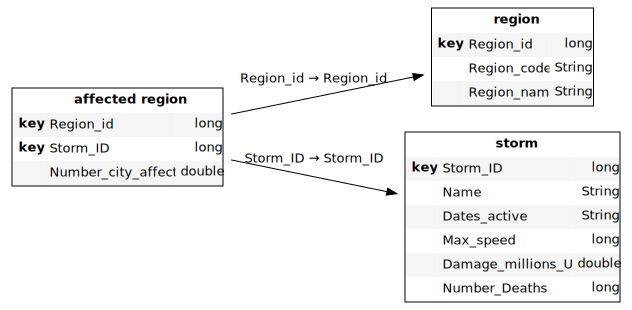

In [4]:
cube.schema

### Create hierarchy

### Create Measures

In [5]:
m["Speed.VALUE"] = tt.value(storm_store["Max_speed"])
m["Speed.MAX"] = tt.agg.max(storm_store["Max_speed"])
m["Speed.MIN"] = tt.agg.min(storm_store["Max_speed"])
m["Speed.MEAN"] = tt.agg.mean(storm_store["Max_speed"])


m["Damage millions usd.VALUE"] = tt.value(storm_store["Damage_millions_USD"])
m["Damage millions usd.MAX"] = tt.agg.max(storm_store["Damage_millions_USD"])
m["Damage millions usd.MIN"] = tt.agg.min(storm_store["Damage_millions_USD"])
m["Damage millions usd.MEAN"] = tt.agg.mean(storm_store["Damage_millions_USD"])
m["Damage millions usd.SUM"] = tt.agg.sum(storm_store["Damage_millions_USD"])

m["Number deaths.VALUE"] = tt.value(storm_store["Number_Deaths"])
m["Number deaths.MAX"] = tt.agg.max(storm_store["Number_Deaths"])
m["Number deaths.MIN"] = tt.agg.min(storm_store["Number_Deaths"])
m["Number deaths.MEAN"] = tt.agg.mean(storm_store["Number_Deaths"])
m["Number deaths.SUM"] = tt.agg.sum(storm_store["Number_Deaths"])


m

cube


Cube(_name='Storm', _hierarchies=Hierarchies(), _measures=Measures())

#### Measure Folders

In [6]:
#Measures can be rearranged into folders.
for measure in [
    m["Speed.VALUE"],
    m["Speed.MAX"],
    m["Speed.MIN"],
    m["Speed.MEAN"],
]:
    measure.folder = "Speed"
    
for measure in [
    m["Damage millions usd.VALUE"],
    m["Damage millions usd.MAX"],
    m["Damage millions usd.MIN"],
    m["Damage millions usd.MEAN"],
    m["Damage millions usd.SUM"],
]:
    measure.folder = "Damage"
    
for measure in [
    m["Number deaths.VALUE"],
    m["Number deaths.MAX"],
    m["Number deaths.MIN"],
    m["Number deaths.MEAN"],
    m["Number deaths.SUM"],
]:
    measure.folder = "Death"
m

Measures()

## Visualization Storm Record 

In [7]:
session.url

'http://localhost:49801'